参考文档教程：
https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/

https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_self_rag_local.ipynb



在本教程中，我们将构建一个检索代理。当您希望 LLM 决定是从 vectorstore 检索上下文还是直接响应用户时，检索代理非常有用。

在本教程结束时，我们将完成以下工作：

获取和预处理将用于检索的文档。
为这些文档编制索引以进行语义搜索，并为代理创建检索工具。
构建一个代理 RAG 系统，可以决定何时使用检索工具。

#安装依赖：

## 安装uv

pip install uv -i https://pypi.tuna.tsinghua.edu.cn/simple/

## 利用uv安装

uv pip install langchain  langgraph "langchain[openai]" langchain-community langchain-text-splitters langchain-ollama -i https://pypi.tuna.tsinghua.edu.cn/simple/





# 1. 读取本地txt内容，作为rag的数据源


In [4]:
# 1 读取本地txt，作为rag的参考文献，本文主要读取倚天屠龙记小说；

from langchain_community.document_loaders import  TextLoader

txt_path="data/金庸-倚天屠龙记txt精校版.txt"
docs = [TextLoader(txt_path,encoding='gb18030').load()]
print(len(docs))
docs[0][0].page_content.strip()[:1000]


# 2. 将获取的文档拆分成更小的块，以便索引到我们的 vectorstore 中：

from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1024, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)
print(len(doc_splits))

# 取样100条数据，方便测试，实际使用时，可以全部使用
doc_splits=doc_splits[0:300]

1
2577




# 2. 使用 Ollama 进行嵌入
"""
现在我们有了拆分的文档，我们可以将它们索引到用于语义搜索的向量存储中。

"""
https://www.langchain.com.cn/docs/integrations/text_embedding/ollama/

拉取向量的命令：
ollama pull bge-m3:latest

"""


In [5]:
# 2. 创建检索工具¶
"""
现在我们有了拆分的文档，我们可以将它们索引到用于语义搜索的向量存储中。

2.1. 使用内存中向量存储和 ollama的本地向量模型 嵌入：
"""


from langchain_ollama import OllamaEmbeddings

local_embeddings = OllamaEmbeddings(
    model="bge-m3:latest",
    base_url="192.168.3.136:11434",
)

print(local_embeddings)






model='bge-m3:latest' base_url='192.168.3.136:11434' client_kwargs={} async_client_kwargs={} sync_client_kwargs={} mirostat=None mirostat_eta=None mirostat_tau=None num_ctx=None num_gpu=None keep_alive=None num_thread=None repeat_last_n=None repeat_penalty=None temperature=None stop=None tfs_z=None top_k=None top_p=None


In [ ]:

# 2.2. 使用 LangChain 的预构建创建一个 retriever 工具：create_retriever_tool

# 使用内存向量库
from langchain_core.vectorstores import InMemoryVectorStore

from langchain.tools.retriever import create_retriever_tool


vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=local_embeddings
)
retriever = vectorstore.as_retriever()



retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_novel_info",
    "Search and return information about novel_info.",
)


# 3. 创建llm，搭建rag的流程



In [ ]:
# 3.1 创建llm


from langchain_community.chat_models import ChatOpenAI
import os

API_KEY = "sk-123"

BASE_URL = "https://api.deepseek.com"

os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL

llm = ChatOpenAI(model="deepseek-chat",temperature=0)



C:\Users\dell\AppData\Local\Temp\ipykernel_32800\1804546767.py:14: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="deepseek-chat",temperature=0)


In [8]:
### 3.2 Retrieval Grader
# 检索 评分者
"""您是一名评分员，评估检索文档与用户问题的相关性。\ n
下面是检索到的文档：  {document} \n\n
下面是用户的问题：{question} \n
如果文档包含与用户问题相关的关键字，则将其评分为相关。\ n
这并不需要严格的测试。目标是过滤掉错误的检索。\ n
给出一个二元分数“是”或“否”，以表明该文档是否与问题相关。\ n
将二进制得分提供为一个只有一个键` score `的JSON，并且没有预表或解释。
"""


from langchain.prompts import PromptTemplate
# from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser



prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "张翠山是谁"
# k 表示top-k的数量，找到最相关的k个文档

docs = retriever.get_relevant_documents(question,k=10)
print(len(docs))
doc_txt = docs[1].page_content
print(doc_txt)
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
C:\Users\dell\AppData\Local\Temp\ipykernel_32800\2606293649.py:3: SyntaxWarning: invalid escape sequence '\ '
  """您是一名评分员，评估检索文档与用户问题的相关性。\ n
C:\Users\dell\AppData\Local\Temp\ipykernel_32800\2606293649.py:34: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question,k=10)


10
舟中书生站起身来，微微一笑，拱手为礼，左手向着上首的座位一伸，请客人坐下。碧纱灯笼照映下，见这书生手白胜雪，再看他相貌，玉颊微瘦，眉弯鼻挺，一笑时左颊上浅浅一个梨涡，远观之似是个风流俊俏的公子，这时相向而对，显是个女扮男装的妙龄丽人。
　　张翠山虽倜傥潇洒，但师门规矩，男女之防守得极紧。武当七侠行走江湖，于女色上人人律己严谨，他见对方是个女子，一愕之下，登时脸红，站起身来，倒跃回岸，拱手道：“在下不知姑娘女扮男装，多有冒昧。”
　　那少女不答。忽听得桨声响起，小舟缓缓荡向湖心，听那少女抚琴歌道：“今夕兴尽，来宵悠悠，六和塔下，垂柳扁舟。彼君子兮，宁当来游？”舟去渐远，歌声渐低，但见波影浮动，一灯如豆，隐入了湖光水色。
　　在一番刀光剑影、腥风血雨的剧斗后，忽然遇上这等缥缈旖旎的风光，张翠山悄立湖畔，不由得思如潮涌，过了半个多时辰，才回客店。
　　次日临安城中，龙门镖局数十口人命的大血案已传得沸沸扬扬。张翠山外貌蕴藉儒雅，自然谁也不会疑心到他身上。
{'score': 'yes'}


In [9]:
### 3.3 Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print("prompt:{}".format(prompt))

# LLM


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

# 流式输出





e:\miniconda\envs\langgraph_v2\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


prompt:input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]
张翠山是金庸小说《倚天屠龙记》中的主要人物之一，武当派张三丰的第五弟子，武当七侠之一。他性格倜傥潇洒，武功高强，擅长使用“倚天屠龙功”。


In [10]:
### 3.4 Hallucination Grader 幻觉评分员

"""“你是一名评分者，评估一个答案是否基于一组事实。\ n
以下是事实：
\n ------- \n
{文档}
\n ------- \n
下面是答案：{generation}
给出一个“是”或“不是”的二元分数，以表明答案是否有一系列事实支持。\ n
将二进制得分提供为一个只有` score `键的JSON，没有序言或解释。"""



# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
C:\Users\dell\AppData\Local\Temp\ipykernel_32800\3322745778.py:3: SyntaxWarning: invalid escape sequence '\ '
  """“你是一名评分者，评估一个答案是否基于一组事实。\ n


{'score': 'yes'}

In [11]:
### 3.5 Answer Grader  答案评分员
"""你正在评估一个答案是否对解决一个问题有用。\ n
下面是答案：
\n ------- \n
{一代}
\n ------- \n
问题是这样的：{question}
给出一个二元分数“是”或“否”，以表明该答案对解决问题是否有用。\ n
将二进制得分提供为一个只有` score `键的JSON，没有序言或解释。"""


# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
C:\Users\dell\AppData\Local\Temp\ipykernel_32800\2645116219.py:2: SyntaxWarning: invalid escape sequence '\ '
  """你正在评估一个答案是否对解决一个问题有用。\ n


{'score': 'yes'}

In [12]:
### 3.6 Question Re-writer  问题重写器

"""
你是一个问题重写器，它将输入的问题转换为优化过的更好的版本
用于vectorstore检索。看看最初的问题，然后提出一个改进的问题。\ n
这是最初的问题： {question}。改进的无序言问题：

"""
# LLM

# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
print("question:{}".format(question))

question_rewriter.invoke({"question": question})

<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
C:\Users\dell\AppData\Local\Temp\ipykernel_32800\2576231723.py:3: SyntaxWarning: invalid escape sequence '\ '
  """


question:张翠山是谁


'张翠山在金庸武侠小说《倚天屠龙记》中扮演什么角色？他的身世背景和关键情节有哪些？'


# 4. 构建agent，构建流程图



In [13]:
## 4.1  Graph state  构建agent的图

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Nodes

# 检索文件
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question,k=5)
    return {"documents": documents, "question": question}

# 生成答案
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

# 检索的文档评分
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    print("一共检索了{}个段落".format(len(documents)))
          
    # Score each doc
    filtered_docs = []
    curr_index=0
    for d in documents:
        curr_index+=1
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        print("---DOCUMENT SCORE:---")

        grade = score["score"]
        if grade == "yes":
            print("第{curr_index}个段落---GRADE: DOCUMENT RELEVANT---".format(curr_index=curr_index))
            filtered_docs.append(d)
        else:
            print("第{curr_index}个段落---GRADE: DOCUMENT NOT RELEVANT---".format(curr_index=curr_index))
            continue
        

    print("最后筛选后与问题相关的段落有{}个".format(len(filtered_docs)))

    return {"documents": filtered_docs, "question": question}


# 重写问题
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("原始问题：{}".format(question))
    print("重写后的问题：{}".format(better_question))
    return {"documents": documents, "question": better_question}


### Edges

# 确定是生成答案还是重新生成问题。
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


# 确定生成是否基于文档并回答问题。
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    


In [14]:
## 4.2 创建流程图，增加节点和边

from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()




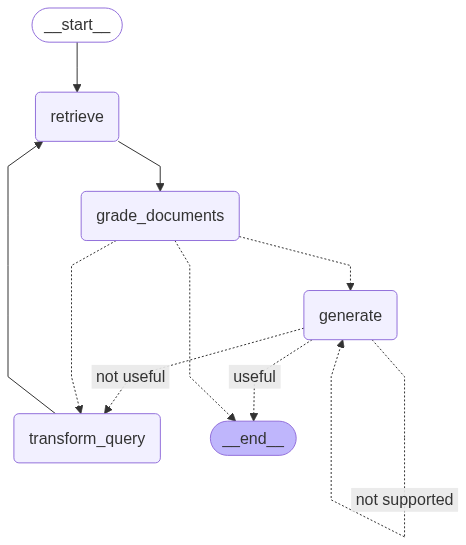

In [15]:
# 4.3 打印输出整体agent的流程图

from IPython.display import Image, display


try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
## 4.4 最后运行这个agent

from pprint import pprint

# Run
inputs = {"question": " 张翠山是谁，他的师傅是谁?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
一共检索了5个段落
---DOCUMENT SCORE:---
第1个段落---GRADE: DOCUMENT RELEVANT---
---DOCUMENT SCORE:---
第2个段落---GRADE: DOCUMENT RELEVANT---
---DOCUMENT SCORE:---
第3个段落---GRADE: DOCUMENT RELEVANT---
---DOCUMENT SCORE:---
第4个段落---GRADE: DOCUMENT RELEVANT---
---DOCUMENT SCORE:---
第5个段落---GRADE: DOCUMENT RELEVANT---
最后筛选后与问题相关的段落有5个
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
'张翠山是金庸小说《倚天屠龙记》中的角色，武当派弟子。他的师傅是武当派创始人张三丰。'
